In [98]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table

#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
gal_name = ['ngc4826']
mode_name = ['SL2', 'SL1', 'LL2', 'LL1']
O2 = 'LL2'

for name in gal_name:
    p_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(name.strip(),O2)
    if(os.path.isfile(p_file)==False):
            print('No such path or file:{0}'.format(p_file))
            continue
    p_fits = fits.open(p_file)
    flux_header = p_fits['PRIMARY'].header
    crval = wcss(flux_header,flux_header['CRPIX1']//2,flux_header['CRPIX2'])
    for mode in mode_name:
        dirs = 'HdrText_{1}/{0}'.format(name.strip(),O2)
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        hdr = open('HdrText_{2}/{0}/{0}_{1}_hdr.txt'.format(name.strip(),mode,O2),'w')
        rp_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(name.strip(), mode)
        rpu_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube_unc.fits'.format(name.strip(), mode)
        if(os.path.isfile(rp_file)==False):
            print('No such path or file:{0}'.format(rp_file))
            continue
        rp_fits = fits.open(rp_file)
        hdr.write('SIMPLE  = T\nBITPIX  = -64\nNAXIS   = 3\n')
        hdr.write('NAXIS1  = {0}\n'.format(str(p_fits[0].header['NAXIS1']+2)))
        hdr.write('NAXIS2  = {0}\n'.format(str(p_fits[0].header['NAXIS2']+2)))
        hdr.write('NAXIS3  = {0}\n'.format(rp_fits[0].header['NAXIS3']))
        hdr.write('CTYPE1  = {0}\n'.format(p_fits[0].header['CTYPE1']))
        hdr.write('CTYPE2  = {0}\n'.format(p_fits[0].header['CTYPE2']))
        hdr.write('EQUINOX  = {0}\n'.format(p_fits[0].header['EQUINOX']))
        hdr.write('CRVAL1  = {0}\n'.format(p_fits[0].header['CRVAL1']))
        hdr.write('CRVAL2  = {0}\n'.format(p_fits[0].header['CRVAL2']))
        hdr.write('CRVAL3  = {0}\n'.format(p_fits[0].header['CRVAL3']))
        hdr.write('CRPIX1  = {0}\n'.format(str(p_fits[0].header['CRPIX1']+1)))
        hdr.write('CRPIX2  = {0}\n'.format(str(p_fits[0].header['CRPIX2']+1)))
        hdr.write('CRPIX3  = {0}\n'.format(p_fits[0].header['CRPIX3']))
        hdr.write('CDELT1  = {0}\n'.format(p_fits[0].header['CDELT1']))
        hdr.write('CDELT2  = {0}\n'.format(p_fits[0].header['CDELT2']))
        hdr.write('CDELT3  = {0}\n'.format(str(0)))
#        hdr.write('PC1_1  = {0}\n'.format(p_fits[0].header['PC1_1']))
#        hdr.write('PC2_1  = {0}\n'.format(p_fits[0].header['PC2_1']))
#        hdr.write('PC1_2  = {0}\n'.format(p_fits[0].header['PC1_2']))
#        hdr.write('PC2_2  = {0}\n'.format(p_fits[0].header['PC2_2']))
        Ro2_s = np.arcsin(p_fits[0].header['PC2_1']*p_fits[0].header['CDELT2']/p_fits[0].header['CDELT1'])*180/np.pi
        Ro22_s = [round(Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,8), round(Ro2_s*180/np.abs(Ro2_s)-Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,8)]
        Ro2_c = np.arccos(p_fits[0].header['PC1_1'])*180/np.pi
        Ro22_c = [round(Ro2_c,8), round(360-Ro2_c,8)]
        Ro2 = list(set(Ro22_s).intersection(Ro22_c))[0]
        hdr.write('CROTA2  = {0}\n'.format(str(Ro2)))
        hdr.write('BUNIT  = MJy_sr^-1\n')
        hdr.write('END')
        hdr.close()
        dirs = 'ProjImg_{1}/{0}'.format(name.strip(),O2)
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        os.system('mProjectCube -f {2} ProjImg_{3}/{0}/{1}_on2_{3}.fits HdrText_{3}/{0}/{0}_{1}_hdr.txt'.format(name.strip(),mode,rp_file,O2))
        os.system('mProjectCube -f {2} ProjImg_{3}/{0}/{1}_on2_{3}_unc.fits HdrText_{3}/{0}/{0}_{1}_hdr.txt'.format(name.strip(),mode,rpu_file,O2))
        rpd_file = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.strip(),mode,O2)
        Spec_hdu = fits.open(rpd_file)[0]
        Wave_hdu = rp_fits[1]
        hdul = fits.HDUList([Spec_hdu,Wave_hdu])
        hdul.writeto('ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.strip(),mode,O2), overwrite = True)
        rpud_file = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.strip(),mode,O2)
        Spec_hdu = fits.open(rpud_file)[0]
        Wave_hdu = rp_fits[1]
        hdul = fits.HDUList([Spec_hdu,Wave_hdu])
        hdul.writeto('ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.strip(),mode,O2), overwrite = True)

In [1]:
def wcss(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_pix2world(x, y ,0)
    return [recx, recy]

In [2]:
def wcss3(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_world2pix(x, y ,0)
    return [recx, recy]

In [15]:
def Spectra_redis(gal_name, O2):
    import os
    import numpy as np
    from astropy import wcs
    from astropy.io import fits
    from astropy.io import ascii
    from astropy.table import Table

#gal_list = open('../subsam_LINER.txt','r')
#gal_name = gal_list.readlines()
#gallist = ['ngc4826', 'ngc4569', 'ngc3351', 'ngc4736']
#    O2 = 'LL2'
    data_mode = ['SL2', 'SL1', 'LL2', 'LL1']
    for name in gal_name:
        nnmm = 'ProjImg_{1}/{0}/'.format(name.strip(),O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            if(mode == 'SL2'):
                apple = max(flux_header['NAXIS1'],flux_header['NAXIS2']) + 5
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = int(round(crpix[0][0],0))
                yy = int(round(crpix[1][0],0))
                ppmax = ppmax + flux[xx, yy].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            aacc = nnmm + '{0}_on2_{1}_unc.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
                cube_u = fits.open(aacc)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            orange = flux_header['NAXIS3']
            banana = np.ones((apple, apple, orange))*np.nan
            banana_u = np.ones((apple, apple, orange))*np.nan
            crpix = wcss3(flux_header, [coor[0][0]], coor[1][0])
            xx = int(round(crpix[0][0],0))
            yy = int(round(crpix[1][0],0))
            mm1 = max(0, xx-apple//2)
            mm2 = min(xx+apple-apple//2,flux_header['NAXIS1'])
            nn1 = max(0, yy-apple//2)
            nn2 = min(yy+apple-apple//2,flux_header['NAXIS2'])
            for ii in range(mm1,mm2):
                for jj in range(nn1,nn2):
                    banana[apple//2 + ii-xx, apple//2 + jj-yy] = flux[ii, jj]
                    banana_u[apple//2 + ii-xx, apple//2 + jj-yy] = flux_u[ii, jj]
            CARD = [('NAXIS1',apple),('NAXIS2',apple),('NAXIS3',orange),('CTYPE1',flux_header['CTYPE1']),('CTYPE2',flux_header['CTYPE2']),
                    ('EQUINOX',flux_header['EQUINOX']),('CRVAL1',coor[0][0]),('CRVAL2',coor[1][0]),('CRVAL3',flux_header['CRVAL3']),
                    ('CRPIX1',apple//2),('CRPIX2',apple//2),('CRPIX3',flux_header['CRPIX3']),('CDELT1',flux_header['CDELT1']),
                    ('CDELT2',flux_header['CDELT2']),('CDELT3',flux_header['CDELT3']),('CROTA2',flux_header['CROTA2']),('BUNIT',flux_header['BUNIT'])]
            hdr = fits.Header(cards= CARD)
            banana = np.transpose(banana, axes=(2, 1, 0))
            primary_hdu = fits.PrimaryHDU(banana, header=hdr)
            hdu_wav = cube['WCS-TAB']
            hdul = fits.HDUList([primary_hdu, hdu_wav])
            dirs = 'reprojectimg/{0}/'.format(name.strip())
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            hdul.writeto('reprojectimg/{0}/{1}_on2_{2}.fits'.format(name.strip(),mode,O2), overwrite = True)
            banana_u = np.transpose(banana_u, axes=(2, 1, 0))
            primary_hdu = fits.PrimaryHDU(banana_u, header=hdr)
            hdu_wav = cube['WCS-TAB']
            hdul = fits.HDUList([primary_hdu, hdu_wav])
            hdul.writeto('reprojectimg/{0}/{1}_on2_{2}_unc.fits'.format(name.strip(),mode,O2), overwrite = True)
###---------------------------------------------------------------------------------------------------------------
        Spec = []
        Spec_u = []
        Wave = []
        img = []
        img_u = []
        for mode in data_mode:
            aadd = 'reprojectimg/{0}/{1}_on2_{2}.fits'.format(name.strip(),mode,O2)
            aaee = 'reprojectimg/{0}/{1}_on2_{2}_unc.fits'.format(name.strip(),mode,O2)
            if(os.path.isfile(aadd)):
                cube = fits.open(aadd)
                cube_u = fits.open(aaee)
            else:
                print('No such file:{0}'.format(aadd))
                continue
            Sspec = cube[0].data
            Sspec_u = cube_u[0].data
            Wwave = cube[1].data
            if(mode == 'SL2'):
                mask = Wwave[0][0] < Wwave[0][0][-3]
                mask = mask.sum(axis=1) == 1
                Spec = Spec + list(Sspec[mask])
                Spec_u = Spec_u + list(Sspec_u[mask])
                Wave = Wave + list(Wwave[0][0][mask])
                detlam = Wwave[0][0][mask][1:] - Wwave[0][0][mask][:-1]
                img = img + list(Sspec[mask]*detlam.mean())
                img_u = img_u + list(Sspec_u[mask]**2*detlam.mean())
            if(mode == 'SL1'):
                mask1 = Wwave[0][0] > Wave[-1][0]
                mask2 = Wwave[0][0] < 14.3
                mask = mask1*mask2
                mask = mask.sum(axis=1) == 1
                Spec = Spec + list(Sspec[mask])
                Spec_u = Spec_u + list(Sspec_u[mask])
                Wave = Wave + list(Wwave[0][0][mask])
                detlam = Wwave[0][0][mask][1:] - Wwave[0][0][mask][:-1]
                img = img + list(Sspec[mask]*detlam.mean())
                img_u = img_u + list(Sspec_u[mask]**2*detlam.mean())
            if(mode == 'LL2'):
                mask1 = Wwave[0][0] > Wave[-1][0]
                mask2 = Wwave[0][0] < 20.6
                mask = mask1*mask2
                mask = mask.sum(axis=1) == 1
                Spec = Spec + list(Sspec[mask])
                Spec_u = Spec_u + list(Sspec_u[mask])
                Wave = Wave + list(Wwave[0][0][mask])
                detlam = Wwave[0][0][mask][1:] - Wwave[0][0][mask][:-1]
                img = img + list(Sspec[mask]*detlam.mean())
                img_u = img_u + list(Sspec_u[mask]**2*detlam.mean())
            if(mode == 'LL1'):
                mask1 = Wwave[0][0] > Wave[-1][0]
                mask2 = Wwave[0][0] < 38
                mask = mask1*mask2
                mask = mask.sum(axis=1) == 1
                Spec = Spec + list(Sspec[mask])
                Spec_u = Spec_u + list(Sspec_u[mask])
                Wave = Wave + list(Wwave[0][0][mask])
                detlam = Wwave[0][0][mask][1:] - Wwave[0][0][mask][:-1]
                img = img + list(Sspec[mask]*detlam.mean())
                img_u = img_u + list(Sspec_u[mask]**2*detlam.mean())
        Spec = np.array(Spec)
        Spec_u = np.array(Spec_u)
        Wave = Table([[Wave]],names = ['WAVELENGTH'], dtype=['float32'])
        Spec_hdu = fits.PrimaryHDU(Spec, header = cube[0].header)
        Spec_hdu.header['NAXIS3'] = len(Wave[0][0])
        Wave_hdu = fits.BinTableHDU(Wave, name='WCS-TAB')
        Wave_hdu.header['TUNIT1'] = 'um'
        hdul = fits.HDUList([Spec_hdu,Wave_hdu])
        hdul.writeto('reprojectimg/{0}/{0}_on2_{1}.fits'.format(name.strip(),O2), overwrite = True)
        Spec_u_hdu = fits.PrimaryHDU(Spec_u, header = cube[0].header)
        Spec_u_hdu.header['NAXIS3'] = len(Wave[0][0])
        hdul_u = fits.HDUList([Spec_u_hdu,Wave_hdu])
        hdul_u.writeto('reprojectimg/{0}/{0}_on2_{1}_unc.fits'.format(name.strip(),O2), overwrite = True)
###---------------------------------------------------------------------------------------------------------------
        img = np.array(img)
        img_u = np.array(img_u)
        img = np.transpose(img, axes=(1, 2, 0))
        img_u = np.transpose(img_u, axes=(1, 2, 0))
        detwav = (Wave[0][0][-1] - Wave[0][0][0]) + (Wave[0][0][-1] - Wave[0][0][-2] + Wave[0][0][2] - Wave[0][0][1])/2
        img = img.sum(axis = 2)/detwav
        img_u = np.sqrt(img_u.sum(axis = 2)/detwav)
        hdr = header = cube[0].header
#        hdr['NAXIS3'] = 1
        Iimg = fits.PrimaryHDU(img, hdr)
        Iimg_u = fits.PrimaryHDU(img_u, hdr)
        Iimg.writeto('reprojectimg/{0}/{0}_on2_{1}_img.fits'.format(name.strip(),O2), overwrite = True)
        Iimg_u.writeto('reprojectimg/{0}/{0}_on2_{1}_img_u.fits'.format(name.strip(),O2), overwrite = True)
###---------------------------------------------------------------------------------------------------------------
        coorx = []
        coory = []
        signal = []
        noise = []
        for i in range(0,hdr['NAXIS1']):
            for j in range(0,hdr['NAXIS2']):
                if(~np.isnan(img[i,j])):
                    coorx.append(j)
                    coory.append(i)
                    signal.append(img[i,j])
                    noise.append(img_u[i,j])
        ascii.write([coorx, coory, signal, noise], 'reprojectimg/{0}/{0}_binning_input.txt'.format(name.strip()), names=['X', 'Y', 'Signal', 'Noise'], format = 'ipac', overwrite = True)
    return

In [16]:
Spectra_redis(['ngc4826'], 'LL2')

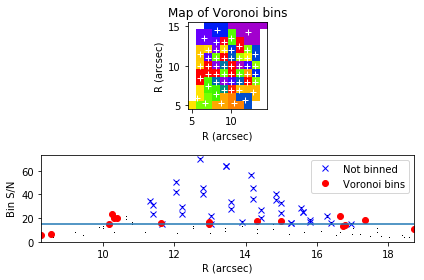

In [17]:
from os import path
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning

#-----------------------------------------------------------------------------

def voronoi_binning_example():
    """
    Usage example for the procedure VORONOI_2D_BINNING.

    It is assumed below that the file voronoi_2d_binning_example.txt
    resides in the current directory. Here columns 1-4 of the text file
    contain respectively the x, y coordinates of each SAURON lens
    and the corresponding Signal and Noise.

    """
    file_dir = path.dirname(path.realpath(vorbin.__file__))  # path of vorbin
#    x, y, signal, noise = np.loadtxt(file_dir + '/voronoi_2d_binning_example_input.txt').T
    in_data = ascii.read('reprojectimg/ngc4826/ngc4826_binning_input.txt',format='ipac')
    x = np.array(in_data['X'])
    y = np.array(in_data['Y'])
    signal = np.array(in_data['Signal'])
    noise = np.array(in_data['Noise'])
    targetSN = 15.0

    # Perform the actual computation. The vectors
    # (binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale)
    # are all generated in *output*
    #
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise, targetSN, plot=1, quiet=1)

    # Save to a text file the initial coordinates of each pixel together
    # with the corresponding bin number computed by this procedure.
    # binNum uniquely specifies the bins and for this reason it is the only
    # number required for any subsequent calculation on the bins.
    #
    np.savetxt('reprojectimg/ngc4826/voronoi_2d_binning_example_output.txt', np.column_stack([x, y, binNum]),
               fmt=b'%10.6f %10.6f %8i')

#-----------------------------------------------------------------------------

if __name__ == '__main__':

    voronoi_binning_example()
    plt.tight_layout()
    plt.pause(1)


In [142]:
import numpy as np

banana = np.ones((2,3,4))
#banana = np.transpose(banana, axes=(2, 1, 0))
~np.isnan(banana[0,0,0])

a = np.array([1, 2, 6])
a.mean()

3.0

In [120]:
import numpy as np
from astropy.io import ascii

x = ascii.read('reprojectimg/ngc4826/ngc4826_binning_input.txt',format='ipac')
np.array(x['X'])

array([ 5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
       15, 15, 15])

SL2


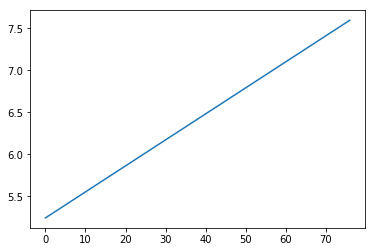

[ 2.10405308 -1.33197362  1.68076574 -0.69443041  2.70192982  3.51891954
  6.67449004  2.51065908         nan         nan]
[[7.4737635]
 [7.504749 ]
 [7.535734 ]
 [7.5667195]
 [7.597705 ]]
SL1


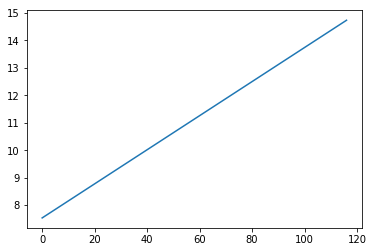

[1.74281916 2.26039432 6.60728423 0.57948272 2.96036293 0.8816895
 2.98783888 4.51039265        nan        nan]
[[14.488258]
 [14.550352]
 [14.612446]
 [14.674541]
 [14.736635]]
LL2


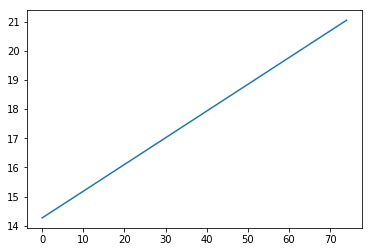

[-5.88294715e-02 -1.26122510e+00 -2.97709942e+00  3.24831605e-02
 -2.38344908e-01 -3.46356958e-01 -8.62371922e-01 -6.82336688e-01
  7.04695238e-03 -4.91665229e-02 -6.49561882e-01 -3.66647094e-01
  1.83690667e-01  7.51695707e-02  1.12786397e-01  1.44185230e-01
 -1.04092740e-01 -1.36768293e+00 -9.32088912e-01 -3.35558176e-01
  1.96212336e-01 -2.81043380e-01  4.68250066e-02 -4.61202599e-02
 -3.15840006e-01  4.28078622e-01 -7.81750619e-01 -2.19191894e-01
 -5.28198332e-02  3.81321549e-01 -3.40817720e-01 -3.68189812e-01
 -5.62710576e-02 -9.80170727e-01  9.29271504e-02  1.14116430e-01
 -1.56536710e-03 -1.29518896e-01 -3.96868467e-01  1.44575990e-03
  4.96233702e-01 -7.73010626e-02  4.77005631e-01  6.03862524e-01
 -2.60975007e-02  4.18189973e-01  6.39055669e-01  1.12721181e+00
  5.02149343e-01  8.58087122e-01  1.91046858e+00  3.45846009e+00
  4.37852001e+00  5.14765072e+00  6.60448170e+00  7.44747734e+00
  7.25172901e+00  7.85824108e+00  8.02238655e+00  7.07372475e+00
  8.01901054e+00  7.16895

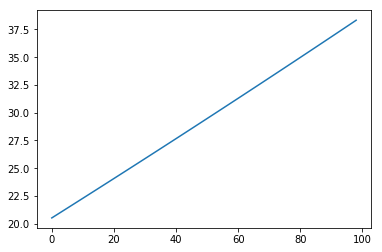

[ 1.60427317e-01 -1.08785344e-01 -1.11712133e+00 -3.05572188e-01
  5.06496739e-01  2.40382722e-01 -5.16867658e-01 -2.05162667e-01
  1.17049497e-01  1.40915747e-02 -4.18804807e-01 -5.93034326e-01
 -4.43537907e-01 -1.48658235e-01 -2.09998083e-01 -3.89722273e-02
  4.05506080e-01  1.20977665e-01  2.45437893e-01  1.78398708e-01
  2.46286596e-01  3.59125222e-01 -4.66138261e-01 -6.83686036e-01
 -2.32842663e-01 -5.13238151e-03  4.19237911e-01 -2.15135585e-02
  3.28817966e-01 -3.65156932e-01 -5.29450801e-01  5.83792864e-01
  1.27397745e-01  4.25491209e-01  6.27070155e-01  4.25468165e-01
  6.46354893e-01  2.44923249e-01 -3.00924983e-01  2.19794165e-01
  6.61792294e-01  5.65918185e-02 -2.28180255e-01  1.79718271e-01
  5.78629052e-01  7.47760998e-01  6.74648807e-01  1.53112207e+00
  1.80824204e+00  1.49588096e+00  1.84584827e+00  2.12547896e+00
  2.18738568e+00  3.92872690e+00  6.11979807e+00  7.81625505e+00
  7.39543747e+00  7.23497625e+00  7.31408326e+00  7.50504462e+00
  8.10993334e+00  7.62874

37.771687

In [140]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

for mode in ['SL2', 'SL1', 'LL2', 'LL1']:
    print(mode)
    sdu = fits.open('ProjImg_LL2/ngc4826/{0}_on2_LL2.fits'.format(mode))
    plt.plot(sdu[1].data[0][0])
    plt.show()
#print(sdu[1].header)
#    mask = sdu[0].data < 0
#    print(mask.sum())
    print(sdu[0].data[0][0])
    print(sdu[1].data[0][0][-5:])
    mask1 = sdu[1].data[0][0] < 5.5
    mask2 = sdu[1].data[0][0] < 6
    mask = mask1*mask2
#    print(mask)
    mask = mask.sum(axis=1) == 1
#    print(mask)
    a = list(sdu[1].data[0][0][:-3])
a[-1][0]

In [131]:
tt = np.array([True, True, False])
tt.sum()

2

In [90]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table

#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
gal_name = ['ngc4826']
mode_name = ['SL2', 'SL1', 'LL2', 'LL1']
O2 = 'LL2'

for name in gal_name:
    p_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(name.strip(),O2)
    if(os.path.isfile(p_file)==False):
            print('No such path or file:{0}'.format(p_file))
            continue
    p_fits = fits.open(p_file)
    flux_header = p_fits['PRIMARY'].header
    crval = wcsss(flux_header,flux_header['CRPIX1']//2,flux_header['CRPIX2'])
    for mode in mode_name:
        dirs = 'HdrText_{1}/{0}'.format(name.strip(),O2)
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        hdr = open('HdrText_{2}/{0}/{0}_{1}_hdr.txt'.format(name.strip(),mode,O2),'w')
        rp_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(name.strip(), mode)
        rpu_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube_unc.fits'.format(name.strip(), mode)
        if(os.path.isfile(rp_file)==False):
            print('No such path or file:{0}'.format(rp_file))
            continue
        rp_fits = fits.open(rp_file)
        hdr.write('SIMPLE  = T\nBITPIX  = -64\nNAXIS   = 3\n')
        hdr.write('NAXIS1  = {0}\n'.format(str(100)))
        hdr.write('NAXIS2  = {0}\n'.format(str(100)))
        hdr.write('NAXIS3  = {0}\n'.format(rp_fits[0].header['NAXIS3']))
        hdr.write('CTYPE1  = {0}\n'.format(p_fits[0].header['CTYPE1']))
        hdr.write('CTYPE2  = {0}\n'.format(p_fits[0].header['CTYPE2']))
        hdr.write('EQUINOX  = {0}\n'.format(p_fits[0].header['EQUINOX']))
        hdr.write('CRVAL1  = {0}\n'.format(str(crval[0])))
        hdr.write('CRVAL2  = {0}\n'.format(str(crval[1])))
        hdr.write('CRVAL3  = {0}\n'.format(p_fits[0].header['CRVAL3']))
        hdr.write('CRPIX1  = {0}\n'.format(str(p_fits[0].header['CRPIX1']//2)))
        hdr.write('CRPIX2  = {0}\n'.format(str(p_fits[0].header['CRPIX2'])))
        hdr.write('CRPIX3  = {0}\n'.format(p_fits[0].header['CRPIX3']))
        hdr.write('CDELT1  = {0}\n'.format(p_fits[0].header['CDELT1']))
        hdr.write('CDELT2  = {0}\n'.format(p_fits[0].header['CDELT2']))
        hdr.write('CDELT3  = {0}\n'.format(str(0)))
#        hdr.write('PC1_1  = {0}\n'.format(p_fits[0].header['PC1_1']))
#        hdr.write('PC2_1  = {0}\n'.format(p_fits[0].header['PC2_1']))
#        hdr.write('PC1_2  = {0}\n'.format(p_fits[0].header['PC1_2']))
#        hdr.write('PC2_2  = {0}\n'.format(p_fits[0].header['PC2_2']))
        Ro2_s = np.arcsin(p_fits[0].header['PC2_1']*p_fits[0].header['CDELT2']/p_fits[0].header['CDELT1'])*180/np.pi
        Ro22_s = [round(Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,8), round(Ro2_s*180/np.abs(Ro2_s)-Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,8)]
        Ro2_c = np.arccos(p_fits[0].header['PC1_1'])*180/np.pi
        Ro22_c = [round(Ro2_c,8), round(360-Ro2_c,8)]
        Ro2 = list(set(Ro22_s).intersection(Ro22_c))[0]
        hdr.write('CROTA2  = {0}\n'.format(str(Ro2)))
        hdr.write('BUNIT  = MJy_sr^-1\n')
        hdr.write('END')
        hdr.close()
        dirs = 'ProjImg_{1}/{0}'.format(name.strip(),O2)
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        os.system('mProjectCube -f {2} ProjImg_{3}/{0}/{1}_on2_{3}.fits HdrText_{3}/{0}/{0}_{1}_hdr.txt'.format(name.strip(),mode,rp_file,O2))
        os.system('mProjectCube -f {2} ProjImg_{3}/{0}/{1}_on2_{3}_unc.fits HdrText_{3}/{0}/{0}_{1}_hdr.txt'.format(name.strip(),mode,rpu_file,O2))
        rpd_file = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.strip(),mode,O2)
        Spec_hdu = fits.open(rpd_file)[0]
        Wave_hdu = rp_fits[1]
        hdul = fits.HDUList([Spec_hdu,Wave_hdu])
        hdul.writeto('ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.strip(),mode,O2), overwrite = True)
        rpud_file = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.strip(),mode,O2)
        Spec_hdu = fits.open(rpud_file)[0]
        Wave_hdu = rp_fits[1]
        hdul = fits.HDUList([Spec_hdu,Wave_hdu])
        hdul.writeto('ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.strip(),mode,O2), overwrite = True)